## LFP Preprocessing

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.


01082025 - repreprocessed with check_bad as True, need to add MS057 (w updated labels)->> no longer doing this

In [11]:
import sys
sys.path.append('/hpc/users/tostag01/LFPAnalysis/')

In [12]:
from LFPAnalysis_GT import SNT_utils, lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [13]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
import scipy

# I only want to see warnings once
warnings.filterwarnings('ignore')

In [15]:
import datetime
date = datetime.date.today().strftime('%m%d%Y')
print(date)

02172025


In [16]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.26.4
mne==1.8.0
seaborn==0.13.2
pandas==2.2.3
joblib==1.4.2
scipy==1.14.1


## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference 

In [17]:
subj_ids = ['MS008', 'MS009', 'MS019','MS020', 'MS030', 'MS034', 'MS042', 'MS043', 'MS045', 'MS047', 'MS048', 'MS050', 'MS051', 'MS053', 'MS054', 'MS055', 'MS056', 'MS057', 'MS058']
## ms052 too spikey across the board
# subj_ids = ['MS058']
subj_sites = ['MSSM' for _ in subj_ids]
subj_formats = ['edf' for _ in subj_ids]
base_dir = '/sc/arion/projects/OlfMem/tostag01/SocialNav'

In [18]:
load_preproc_data = True
load_reref_data = True
load_clean_reref = True

In [19]:
# bad channels determined by psd and/or trial-averaged TFRs
bad_reref_ch = {
    'MS008':['lagit7-lagit8', 'racas3-racas4', 'racas4-racas5'],
    'MS009':['lptpt8-lptpt9'],
    'MS019':['lsppc9-lsppc10',  'lhpit1-lhpit2', 'lhpit2-lhpit3'],
    'MS020':['lmcms2-lmcms3', 'lhpit1-lhpit2', 'lhpit2-lhpit3', 'lhpit3-lhpit4', 'lhpit5-lhpit6', 'lmolf1-lmolf2', 'lmolf3-lmolf4', 'lmolf4-lmolf5'],
    'MS030':['lpcag2-lpcag3', 'lpcag11-lpcag12'],
    'MS034':['lmipop8-lmipop9'],
    'MS042':['lpvag11-lpvag12', 'lpvag12-lpvag13'],
    'MS043':['lhplt3-lhplt4', 'raglt9-raglt10', 'raglt10-raglt11'],
    'MS045':['lcm2-lcm3', 'lcm3-lcm4', 'lhpit8-lhpit9', 'ragit1-ragit2', 'ragit2-ragit3', 'ragit3-ragit4', 'ragit6-ragit7', 'ragit7-ragit8', 'rmoct1-rmoct2','rmoct2-rmoct3', 'rmoct3-rmoct4', 'rmoct4-rmoct5','rmoct5-rmoct6', 'rmoif9-rmoif10', 'rprect10-rprect11'],
    'MS047':['lpoper7-lpoper8'],
    'MS048':[],
    'MS050':['lagit1-lagit2', 'lagit2-lagit3', 'rcmsmg1-rcmsmg2'],
    'MS051':['rhpit3-rhpit4',  'lhpit2-lhpit3'],
    'MS053':['lpcsm11-lpcsm12', 'lpcsm12-lpcsm13'],
    'MS054':['lpihs1-lpihs2', 'lpihs2-lpihs3', 'racas1-racas2', 'raglt1-raglt2'],
    'MS055':['laglt3-laglt4'],
    'MS056':['rhscl7-rhscl8'],
    'MS057':[],
    'MS058':['lagm11-lagm12', 'lhcpp11-lhcpp12', 'lmtit1-lmtit2']}
   

In [20]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]
    
    ### Pre-process data
    if load_preproc_data:
        mne_data = mne.io.Raw(f'{save_path}raw_ieeg.fif', preload=True)
        
    else:
        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_path=elec_file,
                                                 format=format,
                                                 return_data=True,
                                                 site=site,
                                                 check_bad=False) # changed this to not annotate anything as bad 

        # Save this data so that you don't need this step again:
        mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)
        
    ### Bipolar re-reference data
    if load_reref_data:
        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
        if load_clean_reref:
            print(f'Loading cleaned bp data for {subj_id}')
            mne_data_reref.info['bads'] = bad_reref_ch[subj_id]
            mne_data_reref.save(f'{save_path}/clean_ieeg_bp.fif', overwrite=True)
            
    else:
        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='bipolar', 
                                                  site=site)

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/ieeg_bp.fif', overwrite=True)

    # Should also save out re-referenced elec_file: 
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

    # Add region to the data frame 

    manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
    all_regions = [] 
    for chan_name in elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
        all_regions.append(elec_region) 

    elec_df['SNT_region'] = all_regions
    elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

    elec_df.to_csv(f'{save_path}/labels_bp', index=False)


Working on subj MS008
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS008/LFP/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS008/LFP//ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Loading cleaned bp data for MS008
Overwriting existing file.
Writing /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS008/LFP/clean_ieeg_bp.fif
Closing /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS008/LFP/clean_ieeg_bp.fif
[done]
Working on subj MS009
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS009/LFP/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Op

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

## NOW look at the data to manually remove channels: 

After bipolar referencing: 

In [10]:
%matplotlib notebook 

In [13]:
# Scroll up/down and left/right using your keyboard. CLICK on a channel to turn it 'grey' and mark as a 'bad' channel. 
# If you click a grey channel again it will unmark it. 

mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data_reref._data.max()/30
                     )

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP//ieeg_bp.fif...
    Range : 0 ... 1346218 =      0.000 ...  2692.436 secs
Ready.
Reading 0 ... 1346218  =      0.000 ...  2692.436 secs...
Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

In [14]:
# ALSO look at the power spectra! 
# You can click on channels here to identify them, and go back to the viz above to mark them as noise if need be

mne_data_reref.compute_psd().plot()

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

First, you may need to MANUALLY clean the photodiode signal if the recording quality is poor. Load it, plot it, and try to isolate/amplify the pulses. 

In [14]:
plots_dir = f'{base_dir}/plots/alignment/'

In [21]:
inverted_diode_subj = {'MS008','MS009', 'MS019', 'MS020', 'MS030', 'MS051', 'MS053', 'MS054', 'MS055','MS057'}

Working on subj MS055
1 responses missed for MS055
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS055/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 2791999 =      0.000 ...  2726.562 secs
Ready.
Reading 0 ... 2791999  =      0.000 ...  2726.562 secs...
There are 198 neural syncs detected
Max rval with slope of 0.9999820031142573 and offset of -329.6666628424019


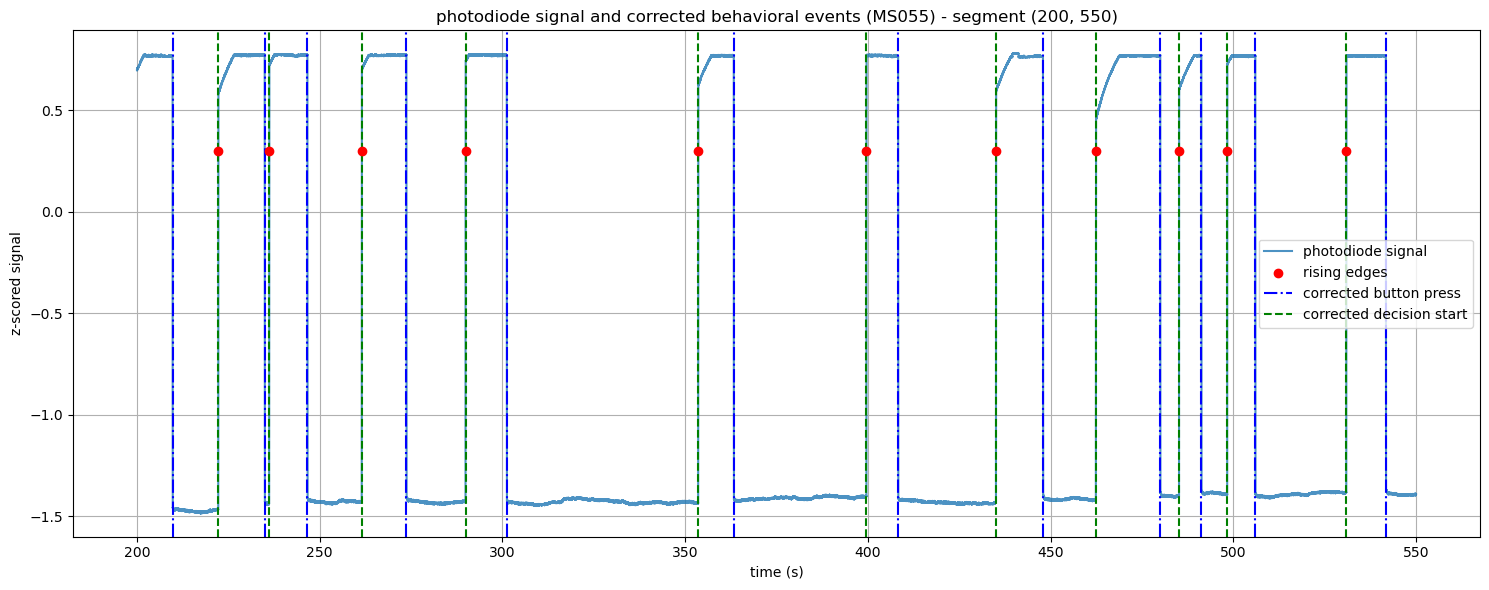

Working on subj MS056
0 responses missed for MS056
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS056/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 2455039 =      0.000 ...  2397.499 secs
Ready.
Reading 0 ... 2455039  =      0.000 ...  2397.499 secs...
There are 488 neural syncs detected
Max rval with slope of 0.0008339035638604079 and offset of 2311.5315237534205


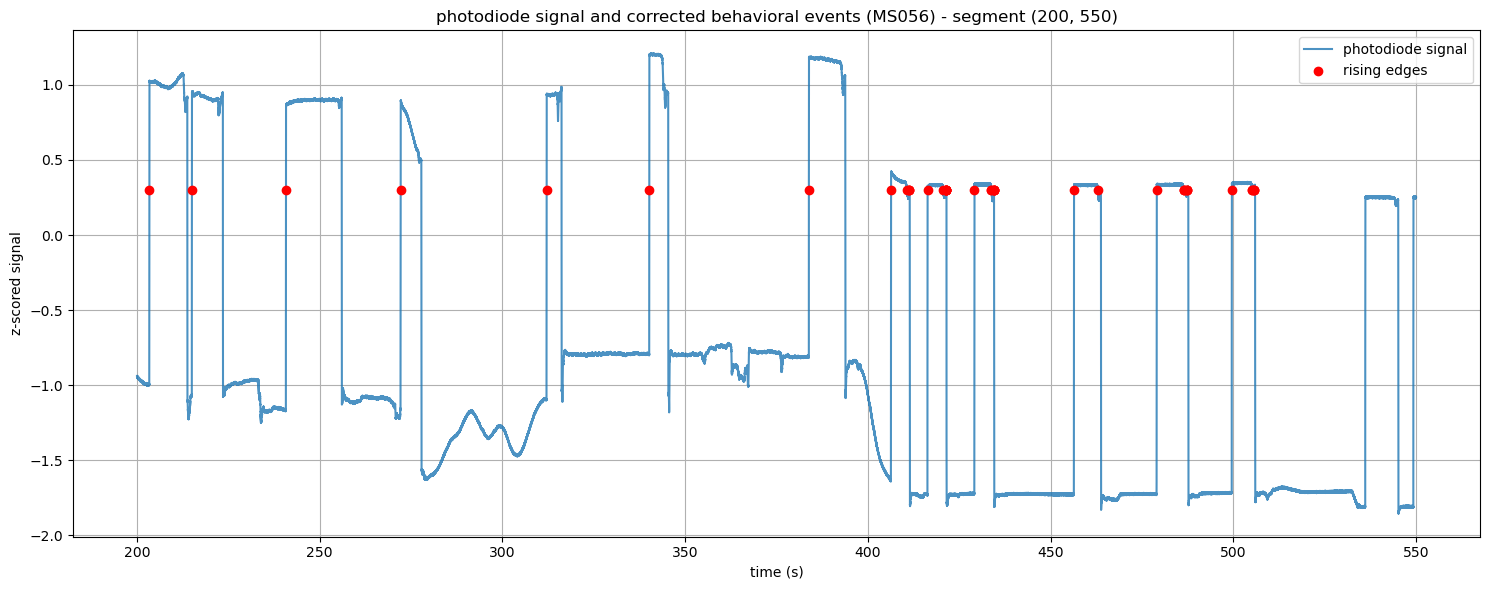

Working on subj MS058
4 responses missed for MS058
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS058/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 3742015 =      0.000 ...  3654.312 secs
Ready.
Reading 0 ... 3742015  =      0.000 ...  3654.312 secs...
There are 411 neural syncs detected
Max rval with slope of 0.992992156839462 and offset of -81.0859056711783


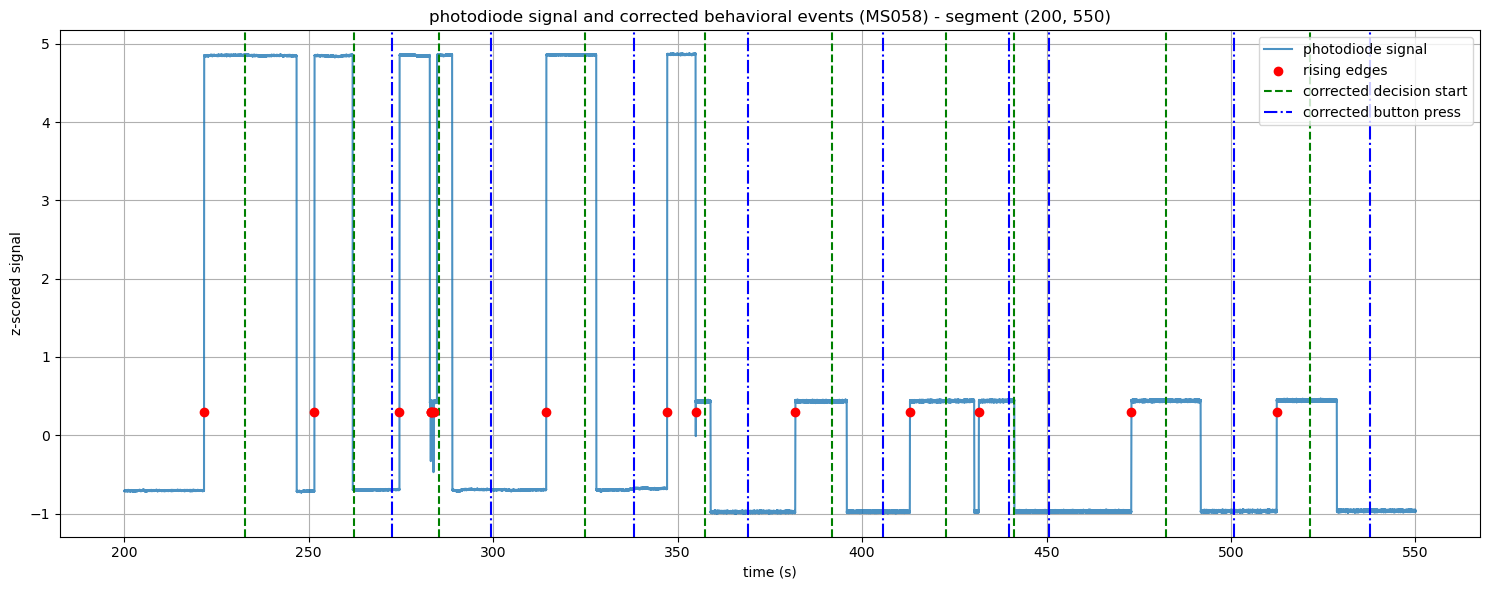

In [22]:
slopes = {f'{x}': [] for x in subj_ids}
offsets = {f'{x}': [] for x in subj_ids}

for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'

    behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
    log_file = glob(f'{behav_path}/*.log')[0]
    time_df_ = SNT_utils.parse_logfile(log_file)
    # time_df = time_df.loc[time_df['rt'] != 0.0] # remove trials with 0 reaction times, likely fluke
    time_df = add_next_narration(time_df_) # add the times of the narrative trial following choice for baseline
    time_df = add_previous_narration(time_df_) # add the times of the narrative trial before choice for baseline
    time_df.to_csv(f'{base_dir}/preproc/{subj_id}/behav/{subj_id}_time_df.csv', index=False)
    missing_responses = time_df[(time_df['decision_trial_start'].notna()) & (time_df['rt'] == 0)]
    print(f'{missing_responses.shape[0]} responses missed for {subj_id}')

    beh_ts = time_df['decision_trial_start'].values
    beh_ts = beh_ts[~np.isnan(beh_ts)]
    print(f'There are {len(beh_ts)} behav syncs detected')
    
    # Synchronize to the photodiode or whatever your neural sync signal is
    if subj_id == 'MS038':
        photodiode_data = mne.io.read_raw_fif(f'{save_path}clean_photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,600000:]
        smoothSize=35 
        windSize=20
        height=5.6       
        
    elif subj_id == 'MS034':
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,:1750000]
        smoothSize=15
        windSize=15
        height=0.3

    elif subj_id == 'MS042':
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,:1800000]
        smoothSize=15
        windSize=15
        height=0.3

    elif subj_id == 'MS043':
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,0:1540000]
        smoothSize=15
        windSize=15
        height=0.3
        
    else:
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        if subj_id in inverted_diode_subj:
            photodiode_data._data *= -1 #invert
        smoothSize=15
        windSize=15
        height=0.3
        if subj_id == 'MS057':
            height=0.1

#     try:
#         slope, offset = sync_utils.synchronize_data(beh_ts, 
#                             photodiode_data, 
#                             smoothSize=11, windSize=15,
#                             height=0.8)
        
#     except Exception:
#         try:
#             print("fast and robust sync failed - trying simple sync now")
#             slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
#         except Exception as e:
#             raise RuntimeError("Both synchronization methods failed. Please review parameters.") from e
    
    try:
        slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height, plot_alignment=False)
    except Exception as e:
        raise RuntimeError("Sync failed. Please review parameters or try another method") from e

    # plt.savefig(f'{plots_dir}{subj_id}_{date}.png', dpi=300)
    plot_save_path = f'{plots_dir}{subj_id}_photodiode_behavior_alignment_{date}.png'
    
    segment = (200,550)
    SNT_utils.visualize_photodiode_and_behavior(
        photodiode_data, 
        time_df, 
        subj_id, 
        slope=slope, 
        offset=offset, 
        smoothSize=smoothSize, 
        height=height, 
        plot_save_path=plot_save_path, 
        segment=segment)
    plt.show()
    slopes[subj_id].append(slope)
    offsets[subj_id].append(offset)

alignment_df = pd.DataFrame({
    'subj_id': slopes.keys(),
    'slope': [v[0] for v in slopes.values()],
    'offset': [v[0] for v in offsets.values()]
})
# alignment_df.set_index('subj_id', inplace=True)
# alignment_df.to_csv(f'{base_dir}/preproc/slopes_offsets.csv')
# print('Saved slopes and offsets')

In [16]:
def add_previous_narration(df):
    """
    adds a column to the dataframe for the previous non-decision trial start time before each choice.

    parameters:
    ----------
    df : pd.dataframe
        dataframe with 'choice_start' and 'non_decision_trial_start' columns.

    returns:
    -------
    df : pd.dataframe
        modified dataframe with a new column 'previous_non_decision_trial_start'.
    """
    previous_non_decision_times = []

    for idx, row in df.iterrows():
        # if this row corresponds to a decision trial with a valid choice
        if pd.notna(row['choice_start']):
            # find the previous non-decision trial before the current index
            previous_non_decision = df.loc[:idx - 1][df['non_decision_trial_start'].notna()]
            
            if not previous_non_decision.empty:
                # append the time of the most recent previous non-decision trial
                previous_non_decision_times.append(previous_non_decision['non_decision_trial_start'].iloc[-1])
            else:
                # no prior non-decision trial found, append nan
                previous_non_decision_times.append(None)
        else:
            # for non-decision trials or decision trials without a valid choice, append nan
            previous_non_decision_times.append(None)

    # add the list as a new column in the dataframe
    df['previous_non_decision_trial_start'] = previous_non_decision_times

    return df

def add_next_narration(df):
    next_non_decision_times = []

    for idx, row in df.iterrows():
        # if this row corresponds to a decision trial with a valid choice
        if pd.notna(row['choice_start']):
            # find the next non-decision trial after the current index
            next_non_decision = df.loc[idx+1:][df['non_decision_trial_start'].notna()]
            
            if not next_non_decision.empty:
                # append the time of the first subsequent non-decision trial
                next_non_decision_times.append(next_non_decision['non_decision_trial_start'].iloc[0])
            else:
                # no subsequent non-decision trial found, append NaN
                next_non_decision_times.append(None)
        else:
            # for non-decision trials or decision trials without a valid choice, append NaN
            next_non_decision_times.append(None)
    
    # add the list as a new column in the DataFrame
    df['next_non_decision_trial_start'] = next_non_decision_times

    return df

### If troubleshooting photodiode

In [ ]:
inverted_diode_subj = {'MS008','MS009', 'MS019', 'MS020', 'MS030', 'MS051', 'MS053', 'MS054', 'MS057'}

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS056/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 2455039 =      0.000 ...  2397.499 secs
Ready.
Reading 0 ... 2455039  =      0.000 ...  2397.499 secs...


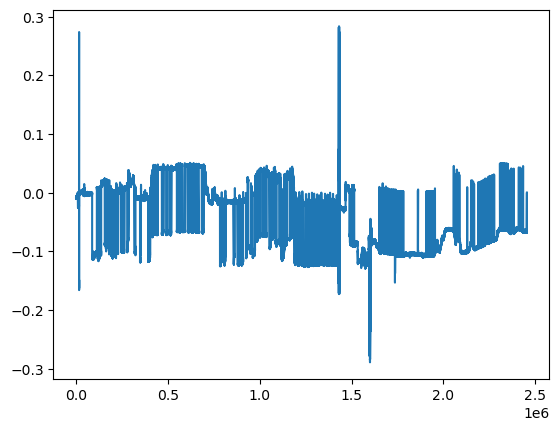

In [32]:
subj_id = 'MS056'
load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
# photodiode_data._data *= -1
plt.plot(photodiode_data._data[0,:])
plt.show()


In [30]:
start_time = 15  # Example: Ignore the first 50 seconds
photodiode_data.crop(tmin=start_time)

<Raw | photodiode.fif, 1 x 2424320 (2367.5 s), ~18.5 MB, data loaded>

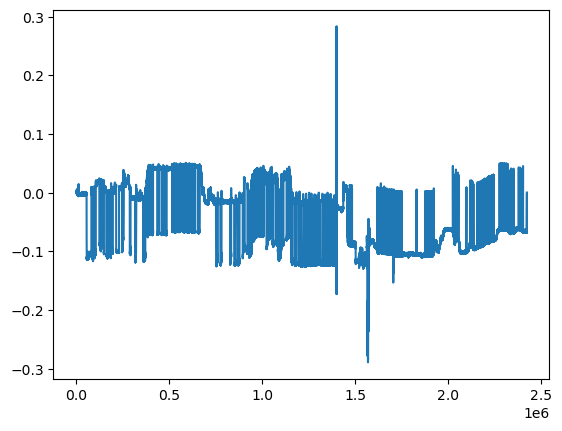

In [31]:
plt.plot(photodiode_data._data[0,:])
plt.show()

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS056/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 2455039 =      0.000 ...  2397.499 secs
Ready.
Reading 0 ... 2455039  =      0.000 ...  2397.499 secs...
There are 872 neural syncs detected
Max rval 0.9980211835309655 with slope of 0.0005154286474460795 and offset of 349.6314606448895


Text(0.5, 1.0, 'Photodiode MS056')

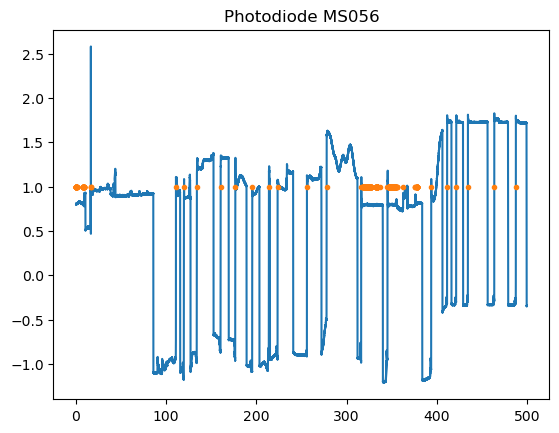

In [27]:
subj_id = 'MS056'
load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
# photodiode_data._data = photodiode_data._data[:,0:1540000]
    

# # # #to invert 
# photodiode_data._data *= -1


smoothSize=30
windSize=30
height=0.8

sig = np.squeeze(sync_utils.moving_average(photodiode_data._data, n=smoothSize))
timestamp = np.squeeze(np.arange(len(sig))/photodiode_data.info['sfreq'])
sig = scipy.stats.zscore(sig)
trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger

neural_ts = timestamp[trig_ix]
neural_ts = np.array(neural_ts)
print(f'There are {len(neural_ts)} neural syncs detected')

nwin = len(neural_ts) - len(beh_ts)
rvals = []
slopes = [] 
offsets = []
for i in range(nwin+1):
    slope, offset, rval = sync_utils.sync_matched_pulses(np.array(beh_ts), neural_ts[i:len(beh_ts)+i])
    rvals.append(rval)
    slopes.append(slope)
    offsets.append(offset)
rvals = np.array(rvals)
offsets = np.array(offsets)
slopes = np.array(slopes)
# print(rvals)
slope=slopes[np.argmax(rvals)]
offset=offsets[np.argmax(rvals)]
print(f'Max rval {np.max(rvals)} with slope of {slope} and offset of {offset}')

sig_indices = [index for index,value in enumerate(timestamp) if value > 0 and value < 500]
neu_indices = [index for index,value in enumerate(neural_ts) if value > 0 and value < 500]
plt.figure()
plt.plot(timestamp[sig_indices], sig[sig_indices])
plt.plot(neural_ts[neu_indices], np.ones_like(neural_ts[neu_indices]), 'o', markersize=3)
plt.title("Photodiode " + subj_id)

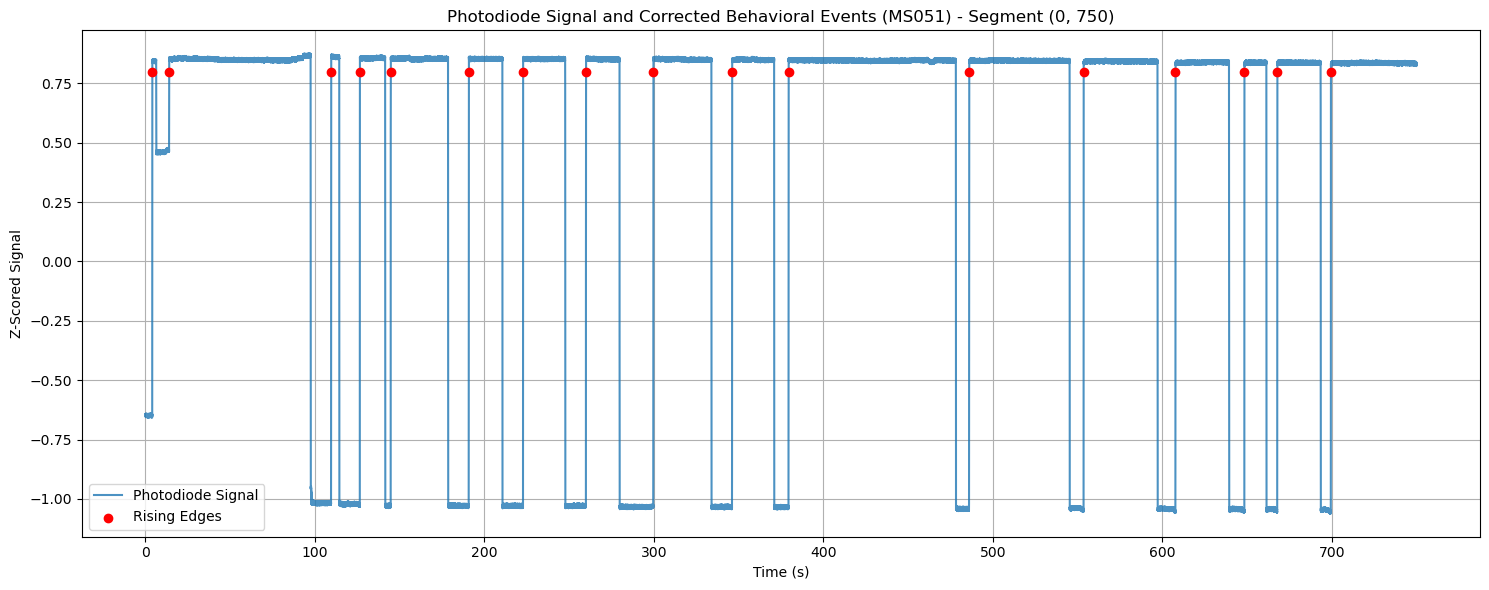

In [88]:
behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
log_file = glob(f'{behav_path}/*.log')[0]
time_df = SNT_utils.parse_logfile(log_file)
segment=(0,750)
visualize_photodiode_and_behavior(
    photodiode_data, 
    time_df, 
    subj_id, 
    slope=slope, 
    offset=offset, 
    smoothSize=smoothSize, 
    height=height, 
    plot_save_path=plot_save_path, 
    segment=segment)

In [78]:
def add_next_narration(df):
    next_non_decision_times = []

    for idx, row in df.iterrows():
        # if this row corresponds to a decision trial with a valid choice
        if pd.notna(row['choice_start']):
            # find the next non-decision trial after the current index
            next_non_decision = df.loc[idx+1:][df['non_decision_trial_start'].notna()]
            
            if not next_non_decision.empty:
                # append the time of the first subsequent non-decision trial
                next_non_decision_times.append(next_non_decision['non_decision_trial_start'].iloc[0])
            else:
                # no subsequent non-decision trial found, append NaN
                next_non_decision_times.append(None)
        else:
            # for non-decision trials or decision trials without a valid choice, append NaN
            next_non_decision_times.append(None)
    
    # add the list as a new column in the DataFrame
    df['next_non_decision_trial_start'] = next_non_decision_times

    return df


## Load your behavioral data & Epoch

Notes:

I also segment a baseline period for every event of interest.

I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later.

The IED count for every channel is added to the epoch metadata

In [8]:
from LFPAnalysis_GT.lfp_preprocess_utils import _bin_channelwise_times_into_behav_evs

In [9]:
def make_epochs(load_path=None, save_path=None,slope=None, offset=None, behav_name=None, behav_times=None,
ev_start_s=0, ev_end_s=1.5, buf_s=1, downsamp_factor=None, IED_args=None, baseline=None, 
nan_artifacts_pre_epoch=True,
detrend=None):

    # elec_path=None,
    """

    TODO: allow for a dict of pre and post times so they can vary across evs 
    
    behav_times: dict with format {'event_name': np.array([times])}
    baseline_times: dict with format {'event_name': np.array([times])}
    IED_args: dict with format {'peak_thresh':5, 'closeness_thresh':0.5, 'width_thresh':0.2}

         elec_data : pandas df 
        dataframe with all the electrode localization information

    Parameters
    ----------
    load_path : str
        path to the re-referenced neural data
    slope : float 
        slope used for syncing behavioral and neural data 
    offset : float 
        offset used for syncing behavioral and neural data 
    behav_name : str
        what event are we epoching to? 
    behav_times : dict 
        format 
    baseline_times : dict 
        format 
    ev_start_s:

    ev_end_s: 

    method : str 
        how should we reference the data ['wm', 'bipolar']
    site : str 
        where was this data collected? Options: ['MSSM', 'UI', 'Davis']

    buf_s : float 
        time to add as buffer in epochs 
    downsamp_factor : float 
        factor by which to downsample the data 
    IED_args: dict 
        format {'peak_thresh':5, 'closeness_thresh':0.5, 'width_thresh':0.2}

    Returns
    -------
    ev_epochs : mne object 
        mne Epoch object with re-referenced data
    """

    # Load the data 
    mne_data_reref = mne.io.read_raw_fif(load_path, preload=True)

    IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_reref, 
                                            peak_thresh=IED_args['peak_thresh'], 
                                            closeness_thresh=IED_args['closeness_thresh'], 
                                            width_thresh=IED_args['width_thresh'])

    artifact_sec_dict = lfp_preprocess_utils.detect_misc_artifacts(mne_data_reref, 
                                            peak_thresh=IED_args['peak_thresh'])                                        

    # all behavioral times of interest 
    beh_ts = [(float(x)*slope + offset) if x != 'None' else np.nan for x in behav_times]

    # any NaN's (e.g. non-responses) should be removed. make sure to remove from the dataframes during later analysis too. 
    beh_ts = [x for x in beh_ts if ~np.isnan(x)]
    
    # Bin these times into the epoched bins
    ev_starts = [x - ev_start_s for x in beh_ts]
    ev_ends = [x + ev_end_s for x in beh_ts]

    IED_df = _bin_channelwise_times_into_behav_evs(IED_sec_dict, ev_starts, ev_ends)
    artifact_df = _bin_channelwise_times_into_behav_evs(artifact_sec_dict, ev_starts, ev_ends)

    # # save these out as csvs in the load path 
    bads_path = os.path.dirname(save_path)
    IED_df.to_csv(f'{bads_path}/{behav_name}_IED_df.csv')
    artifact_df.to_csv(f'{bads_path}/{behav_name}_artifact_df.csv')

    #  it doesn't make sense to nan the raw data before computations 
    # instead, let's just save the indices relative to the epochs and nan them after all is said 

    # if nan_artifacts_pre_epoch:
    #     # NaN out the data corresponding to 100 ms before and after each IED and each artifact: 
    #     for ch_ix, ch_ in enumerate(mne_data_reref.ch_names):  
    #         sig = mne_data_reref.get_data(picks=[ch_])[0, :]  
    #         ieds_ = list(IED_sec_dict[ch_])
    #         artifacts_ = list(artifact_sec_dict[ch_])
    #         all_nan_evs_ = ieds_ + artifacts_
    #         for ev_ in all_nan_evs_: 
    #             # ev_ix = ev_ * mne_data_reref.info['sr']
    #             # remove 100 ms before 
    #             ev_ix_start = np.floor((ev_ - 0.1) * mne_data_reref.info['sfreq']).astype(int)
    #             ev_ix_end = np.ceil((ev_ + 0.1) * mne_data_reref.info['sfreq']).astype(int)
    #             sig[ev_ix_start:ev_ix_end] = np.nan
            
    #         mne_data_reref._data[ch_ix, :] = sig


    # Make behavioral events.
    onset_beh = beh_ts
    duration_beh = np.zeros_like(beh_ts).tolist()
    descriptions_beh = [behav_name]*len(beh_ts)
    ch_names_beh = []*len(beh_ts)

    # Make mne annotations based on these descriptions
    annot = mne.Annotations(onset=onset_beh,
                            duration=duration_beh,
                            description=descriptions_beh)
                
    mne_data_reref.set_annotations(annot)
    events_from_annot, event_dict = mne.events_from_annotations(mne_data_reref)

    ev_epochs = mne.Epochs(mne_data_reref, 
        events_from_annot, 
        event_id=event_dict, 
        baseline=baseline, 
        tmin=ev_start_s - buf_s, 
        tmax=ev_end_s + buf_s, 
        detrend=detrend, 
        reject=None, 
        reject_by_annotation=False,
        preload=True)
        
    # NOTE: I don't demean the data for DC offsets. This is mainly because any undetected large artifact would skew and screw us 
    # before any of the following pre-processing steps, which would be hard to detect later.

    # Filter and downsample the epochs 
    if downsamp_factor is not None:
        ev_epochs.resample(sfreq=ev_epochs.info['sfreq']/downsamp_factor)
        # rm_baseline_epochs.resample(sfreq=ev_epochs.info['sfreq']/downsamp_factor)

    # # 1/19/24: Let's also look for noisy epochs, which can persist even after notch filtering the whole session. 
    # if check_epoch_line_noise == True:
    #     notch_freqs = [120, 180, 240] 
    #     notch_ranges = np.concatenate([np.arange(x-3,x+4) for x in notch_freqs]).flatten().tolist()
    #     noisy_epochs_dict = {f'{x}':np.nan for x in ev_epochs.ch_names}

    #     for ch_ in ev_epochs.ch_names:
    #         sig = ev_epochs.get_data(picks=[ch_])[:,0,:]
    #         noise_evs = []
    #         # compute the power spectrum
    #         freqs, psds = compute_spectrum(sig, ev_epochs.info['sfreq'], method='welch', avg_type='median')

    #         for event in np.arange(sig.shape[0]):
    #             # Find peaks in the power spectrum
    #             peaks, _ = find_peaks(np.log10(psds[event, :]), prominence=3.)  # Adjust threshold as needed
    #             peak_freqs = freqs[peaks]
    #             # do they intersect with noise ranges?
    #             intersection = set(peak_freqs) & set(notch_ranges)
    #             if intersection:
    #                 noise_evs.append(event)
    #         # ev_epochs.metadata.loc[noise_evs, ch_] = 'noise'
    #         noisy_epochs_dict[ch_] = noise_evs
    #     noise_df = pd.DataFrame    
    #     # save out the noisy epochs 
    #     noise_df.to_csv(f'{bads_path}/noise_df.csv')

    return ev_epochs

In [21]:
# Duplicate handling: Ensure each duplicate is preserved by adding a 0.001 offset
def process_duplicate_times(times_list, offset=-0.01):
    """
    Adds a small negative offset to the first occurrence of duplicate times in a list.

    Parameters:
    ----------
    times_list : list of float
        List of timepoints (in seconds).
    offset : float
        The amount to adjust the first duplicate by (default: -0.001 seconds).

    Returns:
    -------
    adjusted_times : list of float
        List of timepoints with the first duplicate adjusted by the specified offset.
    """
    adjusted_times = []
    seen = set()

    for time in times_list:
        # Check if this time has already been seen
        if time in seen:
            # Add the original duplicate (unchanged)
            adjusted_times.append(time)
        else:
            # Add the time, with an offset if it's the first duplicate
            seen.add(time)
            adjusted_times.append(time + offset if times_list.count(time) > 1 else time)

    return adjusted_times

# def make_epochs_SNT(
#     load_path=None,
#     slope=None,
#     offset=None,
#     behav_times=None,  # Can be a dict of {'event_name': [...]} or {'event_name': {'start': [...], 'end': [...]}}
#     buf_s=1,
#     downsamp_factor=None,
#     IED_args=None,
#     baseline=None,
#     nan_artifacts_pre_epoch=True,
#     detrend=None,
# ):
#     """
#     Modified make_epochs function to support both single list of times and variable start/end times.

#     Parameters:
#     ----------
#     behav_times : dict
#         Format 1: {'event_name': [times]} for single event times
#         Format 2: {'event_name': {'start': [times], 'end': [times]}} for variable start and end times
#     """
#     import os
#     import numpy as np
#     import mne

#     # Load the data
#     mne_data_reref = mne.io.read_raw_fif(load_path, preload=True)

#     # Detect artifacts
#     IED_sec_dict = lfp_preprocess_utils.detect_IEDs(
#         mne_data_reref,
#         peak_thresh=IED_args['peak_thresh'],
#         closeness_thresh=IED_args['closeness_thresh'],
#         width_thresh=IED_args['width_thresh'],
#     )
#     artifact_sec_dict = lfp_preprocess_utils.detect_misc_artifacts(
#         mne_data_reref, peak_thresh=IED_args['peak_thresh']
#     )

#     # Process events for each behavioral event type
#     annotations = []
#     for event_name, times in behav_times.items():
#         if isinstance(times, dict):  # Format 2: {'start': [...], 'end': [...]}
#             start_times = times['start']
#             end_times = times['end']

#             # Adjust for slope and offset
#             start_times = [
#                 (float(x) * slope + offset) if x != 'None' else np.nan for x in start_times
#             ]
#             end_times = [
#                 (float(x) * slope + offset) if x != 'None' else np.nan for x in end_times
#             ]

#             # Remove NaNs
#             valid_trials = [(s, e) for s, e in zip(start_times, end_times) if ~np.isnan(s) and ~np.isnan(e)]
#             if not valid_trials:
#                 print(f"Skipping event {event_name} due to missing timestamps.")
#                 continue

#             # Create annotations for this event
#             for start, end in valid_trials:
#                 duration = end - start
#                 annotations.append(
#                     dict(onset=start, duration=duration, description=event_name)
#                 )

#         else:  # Format 1: Single list of times
#             event_times = [
#                 (float(x) * slope + offset) if x != 'None' else np.nan for x in times
#             ]

#             # Remove NaNs
#             valid_times = [x for x in event_times if ~np.isnan(x)]
#             if not valid_times:
#                 print(f"Skipping event {event_name} due to missing timestamps.")
#                 continue

#             # Create annotations for this event
#             for onset in valid_times:
#                 annotations.append(
#                     dict(onset=onset, duration=buf_s * 2, description=event_name)  # Fixed duration using buf_s
#                 )

#     # Convert annotations into MNE-compatible format
#     onset_list = [a['onset'] for a in annotations]
#     duration_list = [a['duration'] for a in annotations]
#     description_list = [a['description'] for a in annotations]
#     annot = mne.Annotations(
#         onset=onset_list,
#         duration=duration_list,
#         description=description_list,
#     )
#     mne_data_reref.set_annotations(annot)

#     # Create events from annotations
#     events_from_annot, event_dict = mne.events_from_annotations(mne_data_reref)

#     # Create epochs
#     ev_epochs = mne.Epochs(
#         mne_data_reref,
#         events=events_from_annot,
#         event_id=event_dict,
#         baseline=baseline,
#         tmin=-buf_s,
#         tmax=buf_s,
#         detrend=detrend,
#         reject=None,
#         reject_by_annotation=False,
#         preload=True,
#     )

#     # Save artifact data
#     bads_path = os.path.dirname(load_path)
#     IED_df = _bin_channelwise_times_into_behav_evs(IED_sec_dict, onset_list, duration_list)
#     artifact_df = _bin_channelwise_times_into_behav_evs(
#         artifact_sec_dict, onset_list, duration_list
#     )
#     IED_df.to_csv(f'{bads_path}/IED_df.csv')
#     artifact_df.to_csv(f'{bads_path}/artifact_df.csv')

#     # Downsample the epochs if needed
#     if downsamp_factor is not None:
#         ev_epochs.resample(sfreq=ev_epochs.info['sfreq'] / downsamp_factor)

#     return ev_epochs


In [22]:
## load saved slopes & offsets
alignment_df = pd.read_csv(f'{base_dir}/preproc/slopes_offsets.csv', index_col='subj_id')

for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    
    slope = alignment_df.loc[subj_id, 'slope']
    offset = alignment_df.loc[subj_id, 'offset']
    print(f'Working on subj {subj_id} with slope {slope} and offset {offset}')
    
    # set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/preproc/{subj_id}/LFP/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/baselineNarr/' ##baselineNarr has narration slides

    if not os.path.exists(save_path):
            os.makedirs(save_path)
    
    behav_path = f'{base_dir}/preproc/{subj_id}/behav/'
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    choice_file = glob(f'{behav_path}*choice_df_all.csv')[0]
    log_file = glob(f'{behav_path}*time_df.csv')[0]
    choice_df = pd.read_csv(choice_file)
    time_df = pd.read_csv(log_file)
    initial_trials = time_df['choice_start'].shape[0]

    # ### drop trials with ITI < 1.5 sec
    # time_df['ITI'] = time_df['next_non_decision_trial_start'] - time_df['choice_start']
    # time_df = time_df.dropna(subset=['ITI'])
    # time_df = time_df[time_df['ITI'] > 1]
    # final_trials = time_df['choice_start'].shape[0]
    # print(f" Dropped trials: {initial_trials - final_trials}")

    # identify duplicates for baseline - should be just two; and none after adjustment
    baseline_times_w_duplicates = pd.Series(time_df['previous_non_decision_trial_start'].dropna().tolist())
    ##### 01/28/25 - pre-narration is best
    # baseline_times_w_duplicates = pd.Series(time_df['next_non_decision_trial_start'].dropna().tolist())
    duplicates = baseline_times_w_duplicates[baseline_times_w_duplicates.duplicated()]
    print(f"Duplicate times for {subj_id}: {duplicates.tolist()}")
    baseline_times = process_duplicate_times(time_df['previous_non_decision_trial_start'].dropna().tolist())
    # baseline_times = process_duplicate_times(time_df['next_non_decision_trial_start'].dropna().tolist())
    duplicates_adj_ = pd.Series(baseline_times)
    duplicates_adj = duplicates_adj_[duplicates_adj_.duplicated()]
    print(f"Duplicate times after adjustment for {subj_id}: {duplicates_adj.tolist()}")

    # # format narration trials start and end (spacebar) - finish this later
    # narration_start = time_df['non_decision_trial_start'].dropna().tolist()
    # narration_stop = time_df['space_press_time'].dropna().tolist()

    
    valid_times = time_df['decision_trial_start'].dropna().values  
    choice_df['closest_match'] = choice_df['onset'].apply(
        lambda x: np.min(np.abs(valid_times - x)) if len(valid_times) > 0 else np.nan
    )
    matching_threshold = 1  
    choice_df_filtered = choice_df[choice_df['closest_match'] < matching_threshold].drop(columns=['closest_match'])
    
    # Verify dimensions and print warnings if mismatched
    if time_df['decision_trial_start'].dropna().shape[0] != choice_df_filtered.shape[0]:
        print(f"⚠️ WARNING: Mismatch in trial counts for subject {subj_id}")
        print(f"   - Time trials after filtering: {time_df['decision_trial_start'].dropna().shape[0]}")
        print(f"   - Choice trials after filtering: {choice_df_filtered.shape[0]}")
    else:
        print(f"✅ Trial count matches for subject {subj_id}")
        
    # define epochs of interest according to timestamps from behavior df 
    # epochs_list = ['baseline', 'decision_time']
    epochs_list = ['narration', 'ITI'] # ITI for narration: 0.5 sec before narr slide
    behav_times = {f'{x}': [] for x in epochs_list}
    # behav_times['baseline'] = np.array(time_df['choice_start'].dropna()) + 0.5 ### 01/29/25 - trying ITI
    # behav_times['baseline'] = baseline_times ### 01/23/25 changed this to be the next narrative trial; 1/27/25 trying the prev narr trial
    # behav_times['decision_time'] = time_df['choice_start'].dropna().tolist()
    behav_times['ITI'] = time_df['non_decision_trial_start'].dropna().tolist()
    behav_times['narration'] = time_df['space_press_time'].dropna().tolist()
    
    #     # for narration baseline Create a dictionary with your event name and the time-window for the event
    # evs = {'decision_time': [-1.5, 0.5], #ChoiceOnset
    #        'baseline': [-0.5, 0]  # baseline, few ms before narration slide
    #       }

        # # Create a dictionary with your event name and the time-window for the event
    evs = {'narration': [-1.5, 0.5], #narration slide
           'ITI': [-0.5, 0]  # baseline, few ms before narration slide
          }


    epochs_all_evs = {f'{x}': np.nan for x in evs}
    buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

    IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

    for event in evs.keys():
        pre = evs[event][0]
        post = evs[event][1]
        fixed_baseline = None

        if event == 'narration' and subj_id in {'MS048', 'MS051'}:
            behav_times['narration'] = time_df['non_decision_trial_start'].dropna() - 0.45

        # THE following function will now SAVE out dataframes that indicate IED and artifact time points in your data
        epochs = make_epochs(load_path=f'{load_path}clean_ieeg_bp.fif', save_path=save_path,
                                                  slope=slope, offset=offset, 
                                                  behav_name=event, behav_times=behav_times[event],
                                                  ev_start_s=pre, ev_end_s=post, buf_s=buf, downsamp_factor=None, IED_args=IED_args, detrend=0)


        epochs_all_evs[event] = epochs
        
        if event in ['decision_time','baseline']:
            print(f'Adding metadata for subj {subj_id} to {event} epoch')
            behav_params = ['decision_num', 'char_decision_num', 'scene_num', 'dimension',
               'char_role_num', 'onset', 'button_press', 'decision', 'affil', 'power',
               'reaction_time', 'char', 'decision_axis', 'x', 'y', 'r_current',
               'r_new', 'angle_current', 'angle_new', 'decision_id', 'raw_angle',
               'raw_angle_new', 'cosine_current', 'cosine_new']

            event_metadata = pd.DataFrame(columns=behav_params)
            choice_df_clean = choice_df_filtered[choice_df_filtered['button_press'] != 0]
            
            for param in behav_params:
                if param in choice_df_clean.columns:
                    event_metadata[param] = choice_df_clean[param].tolist()
                else:
                    print(f"Warning: Parameter {param} not found in choice_df. Filling with NaNs.")
                    event_metadata[param] = np.nan

            # validate metadata alignment
            if len(event_metadata) != len(epochs.events):
                raise ValueError(f"Metadata length ({len(event_metadata)}) does not match number of epochs ({len(epochs.events)}) for {event}")

                
            epochs_all_evs[event].metadata = event_metadata
        
        epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)



    

Working on subj MS008 with slope 0.999997621 and offset -140.0044362
Duplicate times for MS008: [326.1603, 1164.3776]
Duplicate times after adjustment for MS008: []
✅ Trial count matches for subject MS008
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS008/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  73 out of  75 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.8s finished


Used Annotations descriptions: ['narration']
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 148 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS008/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1584499 =      0.000 ...  3168.998 secs
Ready.
Reading 0 ... 1584499  =      0.000 ...  3168.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  73 out of  75 | elapsed:    2.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.7s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS009 with slope 0.999994206 and offset -45.35007285
Duplicate times for MS009: [247.9886, 1626.9519]
Duplicate times after adjustment for MS009: []
✅ Trial count matches for subject MS009
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS009/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.5s finished


Used Annotations descriptions: ['narration']
Not setting metadata
51 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 51 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS009/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1055187 =      0.000 ...  2110.374 secs
Ready.
Reading 0 ... 1055187  =      0.000 ...  2110.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.6s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 1251 original time points ...
1 bad epochs dropped
Working on subj MS019 with slope 1.000005579 and offset -13.32283044
Duplicate times for MS019: [238.875, 1400.5941]
Duplicate times after adjustment for MS019: []
✅ Trial count matches for subject MS019
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS019/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.6s finished


Used Annotations descriptions: ['narration']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS019/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1659187 =      0.000 ...  3318.374 secs
Ready.
Reading 0 ... 1659187  =      0.000 ...  3318.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.7s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS020 with slope 1.000006612 and offset -5.295164106
Duplicate times for MS020: [218.484, 1337.5882]
Duplicate times after adjustment for MS020: []
✅ Trial count matches for subject MS020
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS020/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1161624 =      0.000 ...  2323.248 secs
Ready.
Reading 0 ... 1161624  =      0.000 ...  2323.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.3s finished


Used Annotations descriptions: ['narration']
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 133 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS020/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1161624 =      0.000 ...  2323.248 secs
Ready.
Reading 0 ... 1161624  =      0.000 ...  2323.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.2s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS030 with slope 1.000002 and offset 54.284575
Duplicate times for MS030: [1239.3071]
Duplicate times after adjustment for MS030: []
✅ Trial count matches for subject MS030
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS030/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Reading 0 ... 1497561  =      0.000 ...  2995.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.7s finished


Used Annotations descriptions: ['narration']
Not setting metadata
146 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 146 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS030/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Reading 0 ... 1497561  =      0.000 ...  2995.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    2.8s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS034 with slope 1.000003328 and offset -31.48390682
Duplicate times for MS034: [281.4877, 1360.8822]
Duplicate times after adjustment for MS034: []
✅ Trial count matches for subject MS034
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS034/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1458030 =      0.000 ...  2916.060 secs
Ready.
Reading 0 ... 1458030  =      0.000 ...  2916.060 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.7s finished


Used Annotations descriptions: ['narration']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS034/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1458030 =      0.000 ...  2916.060 secs
Ready.
Reading 0 ... 1458030  =      0.000 ...  2916.060 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    2.7s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS042 with slope 0.999987 and offset -96.963257
Duplicate times for MS042: [1386.7253]
Duplicate times after adjustment for MS042: []
✅ Trial count matches for subject MS042
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS042/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    2.1s finished


Used Annotations descriptions: ['narration']
Not setting metadata
139 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 139 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS042/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1123061 =      0.000 ...  2246.122 secs
Ready.
Reading 0 ... 1123061  =      0.000 ...  2246.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:    2.1s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS043 with slope 1.000009 and offset 11.60013
Duplicate times for MS043: [1132.166]
Duplicate times after adjustment for MS043: []
✅ Trial count matches for subject MS043
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS043/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1087405 =      0.000 ...  2174.810 secs
Ready.
Reading 0 ... 1087405  =      0.000 ...  2174.810 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    1.9s finished


Used Annotations descriptions: ['narration']
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS043/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1087405 =      0.000 ...  2174.810 secs
Ready.
Reading 0 ... 1087405  =      0.000 ...  2174.810 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:    2.0s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS045 with slope 1.000001529 and offset 13.32436047
Duplicate times for MS045: [229.8234, 1166.6779]
Duplicate times after adjustment for MS045: []
✅ Trial count matches for subject MS045
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS045/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1253749 =      0.000 ...  2507.498 secs
Ready.
Reading 0 ... 1253749  =      0.000 ...  2507.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ri

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    4.1s finished


Used Annotations descriptions: ['narration']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS045/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1253749 =      0.000 ...  2507.498 secs
Ready.
Reading 0 ... 1253749  =      0.000 ...  2507.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 124 out of 124 | elapsed:    4.1s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS047 with slope 0.999985349 and offset -101.6652532
Duplicate times for MS047: [304.1454, 1469.0968]
Duplicate times after adjustment for MS047: []
✅ Trial count matches for subject MS047
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS047/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1705593 =      0.000 ...  3411.186 secs
Ready.
Reading 0 ... 1705593  =      0.000 ...  3411.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   17.4s finished


Used Annotations descriptions: ['narration']
Not setting metadata
107 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 107 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS047/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1705593 =      0.000 ...  3411.186 secs
Ready.
Reading 0 ... 1705593  =      0.000 ...  3411.186 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:    3.6s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS048 with slope 1.000433 and offset 791.18555
Duplicate times for MS048: [262.4772, 1852.5873]
Duplicate times after adjustment for MS048: []
✅ Trial count matches for subject MS048
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS048/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1562499 =      0.000 ...  3124.998 secs
Ready.
Reading 0 ... 1562499  =      0.000 ...  3124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    5.2s finished


Used Annotations descriptions: ['narration']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS048/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 1562499 =      0.000 ...  3124.998 secs
Ready.
Reading 0 ... 1562499  =      0.000 ...  3124.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff freque

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    5.2s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS050 with slope 1.000004691 and offset -43.24075683
Duplicate times for MS050: [251.0974, 1300.7493]
Duplicate times after adjustment for MS050: []
✅ Trial count matches for subject MS050
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS050/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 818874 =      0.000 ...  1637.748 secs
Ready.
Reading 0 ... 818874  =      0.000 ...  1637.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed t

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    2.0s finished


Used Annotations descriptions: ['narration']
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 2001 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS050/LFP/clean_ieeg_bp.fif...
    Reading extended channel information
    Range : 0 ... 818874 =      0.000 ...  1637.748 secs
Ready.
Reading 0 ... 818874  =      0.000 ...  1637.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequenc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    2.0s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
    Writing channel names to FIF truncated to 15 characters with remapping
Working on subj MS051 with slope 1.000507 and offset -4.995714
Duplicate times for MS051: [2328.3363]
Duplicate times after adjustment for MS051: []
✅ Trial count matches for subject MS051
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS051/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 2065937 =      0.000 ...  4131.874 secs
Ready.
Reading 0 ... 2065937  =      0.000 ...  4131.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    5.0s finished


Used Annotations descriptions: ['narration']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS051/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 2065937 =      0.000 ...  4131.874 secs
Ready.
Reading 0 ... 2065937  =      0.000 ...  4131.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    5.0s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS053 with slope 0.99998731 and offset -15.65208722
Duplicate times for MS053: [220.2017, 1751.5562]
Duplicate times after adjustment for MS053: []
✅ Trial count matches for subject MS053
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS053/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1588874 =      0.000 ...  3177.748 secs
Ready.
Reading 0 ... 1588874  =      0.000 ...  3177.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.3s finished


Used Annotations descriptions: ['narration']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS053/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1588874 =      0.000 ...  3177.748 secs
Ready.
Reading 0 ... 1588874  =      0.000 ...  3177.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.4s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS054 with slope 0.999985067 and offset -12.59776713
Duplicate times for MS054: [227.8046, 1077.6599]
Duplicate times after adjustment for MS054: []
✅ Trial count matches for subject MS054
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS054/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1163749 =      0.000 ...  2327.498 secs
Ready.
Reading 0 ... 1163749  =      0.000 ...  2327.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    3.3s finished


Used Annotations descriptions: ['narration']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS054/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1163749 =      0.000 ...  2327.498 secs
Ready.
Reading 0 ... 1163749  =      0.000 ...  2327.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    3.3s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS055 with slope 0.999982003 and offset -329.6666628
Duplicate times for MS055: [548.3137, 1585.6136]
Duplicate times after adjustment for MS055: []
✅ Trial count matches for subject MS055
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS055/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1363280 =      0.000 ...  2726.560 secs
Ready.
Reading 0 ... 1363280  =      0.000 ...  2726.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:   10.7s finished


Used Annotations descriptions: ['narration']
Not setting metadata
137 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 137 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS055/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1363280 =      0.000 ...  2726.560 secs
Ready.
Reading 0 ... 1363280  =      0.000 ...  2726.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    4.6s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS056 with slope 0.999997729 and offset -203.6119161
Duplicate times for MS056: [364.5405, 1296.0273]
Duplicate times after adjustment for MS056: []
✅ Trial count matches for subject MS056
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS056/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1198749 =      0.000 ...  2397.498 secs
Ready.
Reading 0 ... 1198749  =      0.000 ...  2397.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    8.3s finished


Used Annotations descriptions: ['narration']
Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 143 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS056/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1198749 =      0.000 ...  2397.498 secs
Ready.
Reading 0 ... 1198749  =      0.000 ...  2397.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    3.8s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS057 with slope 0.999990601 and offset 34.06924943
Duplicate times for MS057: [208.7833, 1219.6008]
Duplicate times after adjustment for MS057: []
✅ Trial count matches for subject MS057
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS057/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1379437 =      0.000 ...  2758.874 secs
Ready.
Reading 0 ... 1379437  =      0.000 ...  2758.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.9s finished


Used Annotations descriptions: ['narration']
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS057/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1379437 =      0.000 ...  2758.874 secs
Ready.
Reading 0 ... 1379437  =      0.000 ...  2758.874 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.8s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 1251 original time points ...
0 bad epochs dropped
Working on subj MS058 with slope 0.999993023 and offset -109.338879
Duplicate times for MS058: [506.9456, 2053.4122]
Duplicate times after adjustment for MS058: []
✅ Trial count matches for subject MS058
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS058/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1827155 =      0.000 ...  3654.310 secs
Ready.
Reading 0 ... 1827155  =      0.000 ...  3654.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    5.4s finished


Used Annotations descriptions: ['narration']
Not setting metadata
95 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 95 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS058/LFP/clean_ieeg_bp.fif...
    Range : 0 ... 1827155 =      0.000 ...  3654.310 secs
Ready.
Reading 0 ... 1827155  =      0.000 ...  3654.310 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.8s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
157 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 157 events and 1251 original time points ...
0 bad epochs dropped


In [36]:
list(time_df['decision_trial_start'].dropna())

[315.942,
 345.8655,
 368.9283,
 408.7063,
 441.4792,
 476.2009,
 507.2718,
 525.9186,
 567.3053,
 606.711,
 678.0704,
 740.8148,
 789.1565,
 827.9927,
 841.5938,
 864.9268,
 909.1741,
 958.7786,
 1005.3293,
 1082.9348,
 1110.031,
 1145.6886,
 1196.3335,
 1236.9988,
 1282.4755,
 1316.9936,
 1362.9605,
 1427.932,
 1465.0192,
 1534.8744,
 1566.7654,
 1596.2809,
 1636.8969,
 1663.6583,
 1698.3419,
 1725.6309,
 1760.3218,
 1796.639,
 1820.4814,
 1867.1626,
 1888.1725,
 1913.2292,
 1952.5724,
 1976.8815,
 1998.4823,
 2018.4248,
 2061.1468,
 2070.8688,
 2109.7134,
 2143.908,
 2171.534,
 2196.8149,
 2231.5127,
 2261.7815,
 2287.7003,
 2320.5894,
 2344.559,
 2380.1893,
 2407.5723,
 2448.1924,
 2476.8105,
 2499.4393,
 2524.6796]

In [39]:
choice_df_filtered.tail(25)

,decision_num,char_decision_num,scene_num,dimension,char_role_num,onset,button_press,decision,affil,power,...,y,r_current,r_new,angle_current,angle_new,decision_id,raw_angle,raw_angle_new,cosine_current,cosine_new
37,38,5,12,power,3,1796.324748,1,1,0,1,...,3,6.324555,6.708204,0,0,1,1.249046,1.107149,0.316228,0.447214
38,39,6,13,affil,3,1820.116928,2,1,1,0,...,3,6.708204,5.830952,0,0,0,1.107149,1.030377,0.447214,0.514496
39,40,7,13,affil,3,1866.783274,1,1,1,0,...,3,5.830952,5.000000,0,0,0,1.030377,0.927295,0.514496,0.600000
40,41,4,14,affil,5,1887.858502,1,1,1,0,...,2,5.385165,4.472136,0,0,0,1.190290,1.107149,0.371391,0.447214
41,42,5,14,affil,5,1912.902959,1,-1,-1,0,...,2,4.472136,5.385165,0,0,0,1.107149,1.190290,0.447214,0.371391
42,43,6,14,power,5,1952.242054,2,1,0,1,...,3,5.385165,5.830952,0,0,1,1.190290,1.030377,0.371391,0.514496
44,45,8,14,affil,5,1998.144601,1,1,1,0,...,3,5.000000,4.242641,0,0,0,0.927295,0.785398,0.600000,0.707107
45,46,9,14,power,5,2018.102897,1,1,0,1,...,4,4.242641,5.000000,0,0,1,0.785398,0.643501,0.707107,0.800000
46,47,10,15,affil,2,2060.846782,2,1,1,0,...,-2,5.385165,4.472136,0,0,0,1.951303,2.034444,-0.371391,-0.447214
47,48,11,15,affil,2,2070.910612,1,1,1,0,...,-2,4.472136,3.605551,0,0,0,2.034444,2.158799,-0.447214,-0.554700


In [34]:
list(choice_df_filtered.onset)

[315.522988599725,
 345.577017399948,
 368.544405799824,
 408.41238419990896,
 441.17133260006,
 475.887897300068,
 506.967157999984,
 525.958181699737,
 566.981514600105,
 606.371675899718,
 677.758764999918,
 740.5052760001269,
 788.8214710000899,
 827.691508799791,
 841.2761234999629,
 864.610637200065,
 908.8048323998221,
 958.406222600024,
 1005.00103429984,
 1082.64472479978,
 1109.65538759995,
 1145.37235469976,
 1195.97566549992,
 1236.62268269993,
 1282.10603130003,
 1316.61553280008,
 1362.64428579993,
 1427.53841219982,
 1464.69463349971,
 1534.58737650001,
 1566.42140699969,
 1595.96981750009,
 1636.53404540009,
 1663.33410289976,
 1698.00107549969,
 1725.28439129982,
 1759.99953919975,
 1796.32474800013,
 1820.11692829988,
 1866.78327360004,
 1887.85850249975,
 1912.90295920008,
 1952.24205410014,
 1998.14460140001,
 2018.10289670014,
 2060.84678249992,
 2070.91061150003,
 2109.3778778999094,
 2143.57284560007,
 2171.19461329979,
 2196.43229290004,
 2231.20601349975,
 2261

In [32]:
list1 = list(time_df['decision_trial_start'].dropna())
list2 = list(choice_df_filtered.onset)

tolerance = 0.01  # Set a small tolerance for mismatch detection

# Find mismatches based on absolute tolerance
mismatches = [(a, b) for a, b in zip(list1, list2) if not np.isclose(a, b, atol=tolerance)]

print("Mismatches within tolerance:", mismatches)


Mismatches within tolerance: [(315.942, 315.522988599725), (345.8655, 345.577017399948), (368.9283, 368.544405799824), (408.7063, 408.41238419990896), (441.4792, 441.17133260006), (476.2009, 475.887897300068), (507.2718, 506.967157999984), (525.9186, 525.958181699737), (567.3053, 566.981514600105), (606.711, 606.371675899718), (678.0704, 677.758764999918), (740.8148, 740.5052760001269), (789.1565, 788.8214710000899), (827.9927, 827.691508799791), (841.5938, 841.2761234999629), (864.9268, 864.610637200065), (909.1741, 908.8048323998221), (958.7786, 958.406222600024), (1005.3293, 1005.00103429984), (1082.9348, 1082.64472479978), (1110.031, 1109.65538759995), (1145.6886, 1145.37235469976), (1196.3335, 1195.97566549992), (1236.9988, 1236.62268269993), (1282.4755, 1282.10603130003), (1316.9936, 1316.61553280008), (1362.9605, 1362.64428579993), (1427.932, 1427.53841219982), (1465.0192, 1464.69463349971), (1534.8744, 1534.58737650001), (1566.7654, 1566.42140699969), (1596.2809, 1595.969817500

In [29]:
from fuzzywuzzy import process

list1 = list(time_df['decision_trial_start'].dropna())
list2 = list(choice_df_filtered.onset)

for num in list1:
    match, score = process.extractOne(num, list2)
    print(f"{word} -> Closest match in list2: {match} (Score: {score})")

ModuleNotFoundError: No module named 'fuzzywuzzy'

In [87]:
time_df.loc[time_df.rt.notna(), "rt"].tolist()[40:50]

[14.6513,
 22.8734,
 18.5591,
 14.9551,
 9.964,
 14.5984,
 8.4713,
 14.9615,
 16.7897,
 9.9824]

In [89]:
time_df.loc[time_df.rt == 14.9551]


,trial,non_decision_trial_start,space_press_time,decision_trial_start,choice_start,rt,key_pressed,photodiode,next_non_decision_trial_start,previous_non_decision_trial_start
169,170,NaN,NaN,1976.8815,1991.8366,14.9551,1.0,white.png,1992.9675,1972.2735


### Plot and examine the epochs if you'd like:

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')